In [36]:
from stream_nwbfile import stream_nwbfile
DANDISET_ID = '000559'
file_path = ('sub-dlight-chrimson-1/sub-dlight-chrimson-1_'
             'ses-reinforcement-photometry-2891f649-4fbd-4119-a807-b8ef507edfab_behavior+image+ogen+ophys.nwb'
)
nwbfile, io = stream_nwbfile(DANDISET_ID, file_path)

In [37]:
sorted_index2id = {
    0: 74,
    1: 20,
    2: 22,
    3: 17,
    4: 86,
    5: 8,
    6: 12,
    7: 91,
    8: 27,
    9: 64,
    10: 95,
    11: 71,
    12: 19,
    13: 44,
    14: 39,
    15: 25,
    16: 65,
    17: 58,
    18: 41,
    19: 47,
    20: 53,
    21: 57,
    22: 94,
    23: 76,
    24: 35,
    25: 92,
    26: 72,
    27: 7,
    28: 5,
    29: 77,
    30: 67,
    31: 33,
    32: 66,
    33: 42,
    34: 15,
    35: 30,
    36: 56,
    37: 11,
    38: 45,
    39: 13,
    40: 73,
    41: 62,
    42: 31,
    43: 59,
    44: 10,
    45: 75,
    46: 4,
    47: 54,
    48: 43,
    49: 26,
    50: 60,
    51: 85,
    52: 29,
    53: 80,
    54: 68,
    55: 38,
    56: 63,
    57: -5
}

In [58]:
import pandas as pd
import numpy as np
from pynwb import NWBHDF5IO
from neuroconv.utils import load_dict_from_file
import matplotlib.pyplot as plt
import colorcet as cc

def reproduce_fig1d(nwbfile, io):
    n_frames = 361
    start = 3520
    start_time = nwbfile.processing["behavior"]["BehavioralSyllableOffline"].timestamps[start]
    stop_time = nwbfile.processing["behavior"]["BehavioralSyllableOffline"].timestamps[start + n_frames]
    photometry_timestamps = nwbfile.processing["ophys"]["ReferenceDfOverF"].timestamps[:]

    signal_dff = nwbfile.processing["ophys"]["SignalDfOverF"].data[:]
    signal_dff = signal_dff[np.logical_and(photometry_timestamps >= start_time, photometry_timestamps < stop_time)]
    reference_dff = nwbfile.processing["ophys"]["ReferenceDfOverF"].data[:]
    reference_dff = reference_dff[
        np.logical_and(photometry_timestamps >= start_time, photometry_timestamps < stop_time)
    ]

    moseq_extract_timestamps = nwbfile.processing["behavior"]["moseq_extract_group"].position.spatial_series['position'].timestamps[:]
    moseq_extract_timemask = np.logical_and(moseq_extract_timestamps >= start_time, moseq_extract_timestamps < stop_time)
    moseq_extract_time = moseq_extract_timestamps[moseq_extract_timemask] - start_time
    position = pd.DataFrame(
        nwbfile.processing["behavior"]["moseq_extract_group"].position.spatial_series['position'].data,
        columns=["x", "y", "height"]
    )
    angle = pd.Series(nwbfile.processing["behavior"]["moseq_extract_group"].heading_2d.spatial_series['heading_2d'].data)
    syllables = pd.Series(nwbfile.processing["behavior"]["BehavioralSyllableOffline"].data).map(sorted_index2id)
    vel_height = position["height"].interpolate(limit_direction="both").diff(2) 
    vel_height = vel_height[moseq_extract_timemask].to_numpy() / 2 * 30
    velocity = np.sqrt(
        position["x"].interpolate(limit_direction="both").diff() ** 2
        + position["y"].interpolate(limit_direction="both").diff() ** 2
    )
    acc = velocity.diff(2)
    acc = acc[moseq_extract_timemask].to_numpy() * 30
    vel = velocity[moseq_extract_timemask].to_numpy() * 30
    vel_angle = angle.interpolate(limit_direction="both").diff(2) * 30 * -1
    vel_angle[np.abs(vel_angle) > 100] = np.NaN # remove artifacts
    vel_angle = vel_angle.interpolate(limit_direction="both")
    vel_angle = vel_angle[moseq_extract_timemask].to_numpy()
    syllables = syllables.iloc[start : start + n_frames].to_numpy()
    t = np.arange(n_frames) / 30

    time = t
    fig, ax = plt.subplots(6, 1)
    fig.dpi = 200

    ax[0].plot(moseq_extract_time, vel, color="k")
    ax[0].set_xlim(time[0], time[-1])
    ax[0].set_xticks([time[0], time[-1]])
    ax[0].set_xticklabels([])
    ax[0].set_ylim(0, 15 * 30)
    ax[0].set_yticks([0, 15 * 30])
    ax[0].set_ylabel("mm/s")
    ax[0].text(0, 1, "Velocity", transform=ax[0].transAxes)
    ax[0].spines["top"].set_visible(False)
    ax[0].spines["right"].set_visible(False)

    ax[1].plot(moseq_extract_time, acc, color="k")
    ax[1].set_xlim(time[0], time[-1])
    ax[1].set_xticks([time[0], time[-1]])
    ax[1].set_xticklabels([])
    ax[1].set_ylim(-5 * 30, 5 * 30)
    ax[1].set_ylabel("mm/s2")
    ax[1].set_yticks([-150, 0, 150])
    ax[1].text(0, 1, "Acceleration", transform=ax[1].transAxes)
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["right"].set_visible(False)

    ax[2].plot(moseq_extract_time, vel_angle, color="k")
    ax[2].set_xlim(time[0], time[-1])
    ax[2].set_xticks([time[0], time[-1]])
    ax[2].set_xticklabels([])
    ax[2].set_ylim(-0.55 * 30, 0.55 * 30)
    ax[2].set_yticks([-16, 0, 16])
    ax[2].set_ylabel("rad/s")
    ax[2].text(0, 1, "Angular velocity", transform=ax[2].transAxes)
    ax[2].spines["top"].set_visible(False)
    ax[2].spines["right"].set_visible(False)

    ax[3].plot(moseq_extract_time, vel_height, color="k")
    ax[3].set_xlim(time[0], time[-1])
    ax[3].set_xticks([time[0], time[-1]])
    ax[3].set_xticklabels([])
    ax[3].set_ylim(-5 * 30, 5 * 30)
    ax[3].set_yticks([-5 * 30, 0, 5 * 30])
    ax[3].set_ylabel("mm/s")
    ax[3].text(0, 1, "Height Velocity", transform=ax[3].transAxes)
    ax[3].spines["top"].set_visible(False)
    ax[3].spines["right"].set_visible(False)

    ax[4].imshow(syllables[np.newaxis, :], aspect="auto", interpolation="none", cmap=cc.cm.glasbey, vmin=0)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[4].text(0, 1.1, "Syllable", transform=ax[4].transAxes)

    ax[5].plot(time, reference_dff, color="#afafaf")
    ax[5].plot(time, signal_dff, color="g")
    ax[5].set_ylim(-0.02, 0.07)
    ax[5].set_yticks([-0.02, 0.07])
    ax[5].set_xlim(time[0], time[-1])
    ax[5].set_xticks([time[0], time[-1]])
    ax[5].set_ylabel("dF/F0")
    ax[5].set_xlabel("Time (seconds)")
    ax[5].spines["top"].set_visible(False)
    ax[5].spines["right"].set_visible(False)

    plt.subplots_adjust(hspace=0.55)
    plt.suptitle("Figure 1d")
    plt.show()

    io.close()

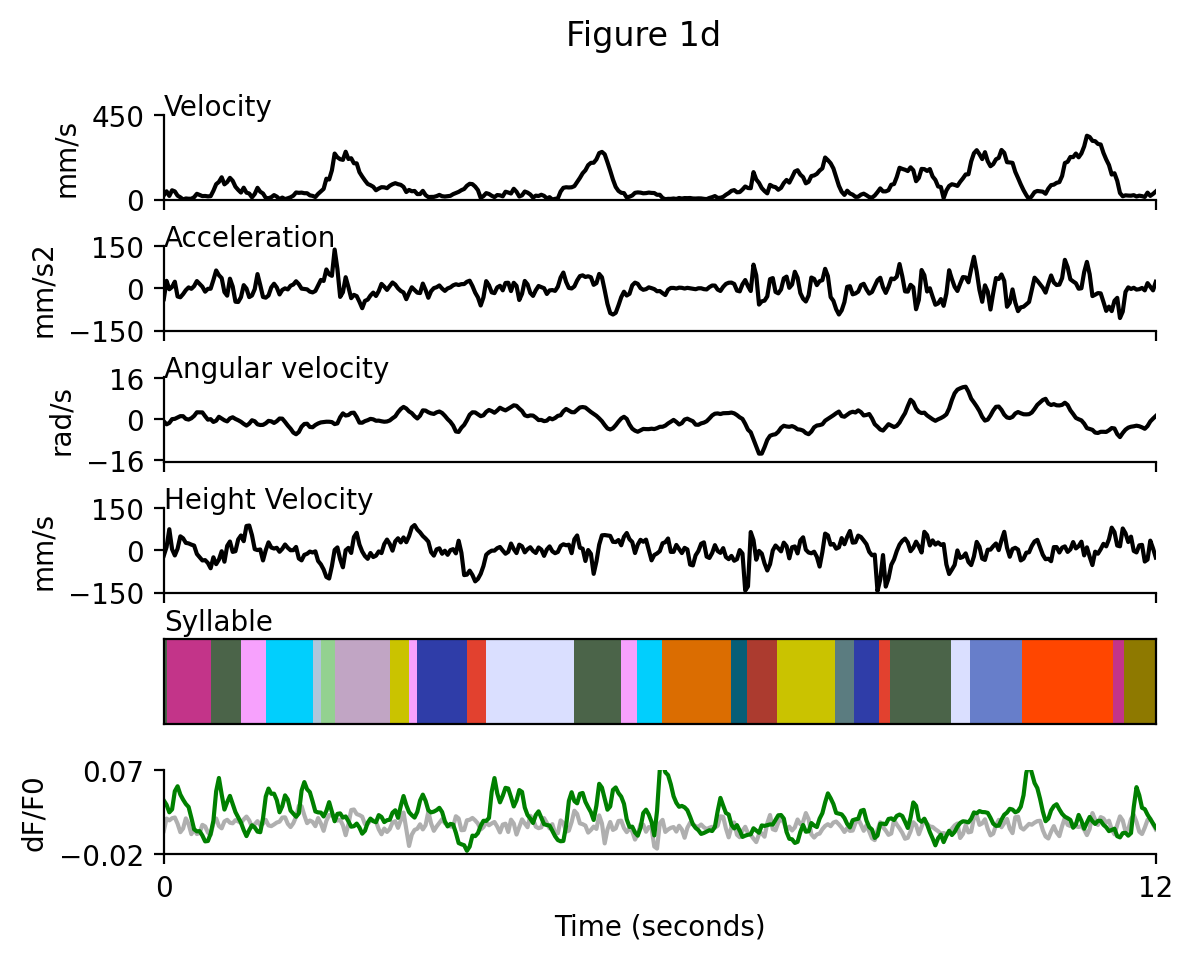

In [59]:
reproduce_fig1d(nwbfile=nwbfile, io=io)